## Data Preparation & Analysis

In [ ]:
#!pip install geopy

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopy
from geopy import distance
import plotly.express as px

import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [83]:
df = pd.read_csv('data/kc_house_data.csv', index_col='id')

In [3]:
for c in df.columns:
    print ("---- %s ---" % c)
    print (df[c].value_counts())
    print("\n")

---- date ---
6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
8/30/2014      1
1/10/2015      1
1/31/2015      1
7/27/2014      1
11/2/2014      1
Name: date, Length: 372, dtype: int64


---- price ---
350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64


---- bedrooms ---
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64


---- bathrooms ---
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6

In [4]:
#Finding which row contains the 33 bedroom home
#Given the square footage it is safe to assume that this is a typo
#Fixing the typo and checking to make sure the 33 is now gone
df.loc[df['bedrooms'] == 33]
df['bedrooms'].replace(33, 3, inplace=True)
df['bedrooms'].value_counts()

3     9825
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

In [58]:
#Seattle (47.605, -122.3344)
#Bellevue (47.601, -122.2015)
bellevue = (47.601, -122.2015)

def distancer(row):
    coords_1 = bellevue
    coords_2 = (row['lat'], row['long'])
    return geopy.distance.distance(coords_1, coords_2).miles

df['distance_from_bellevue'] = df.apply(distancer, axis=1)
distancemap = df[df['price'] <= 1000000] 
fig = px.scatter_mapbox(data_frame = distancemap, lat='lat', lon='long', color='price')

fig.update_layout(mapbox_style="carto-darkmatter")

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['waterfront'] = df['waterfront'].fillna('NO')
df['waterfront'] = df['waterfront'].str.replace('NO', '0')
df['waterfront'] = df['waterfront'].str.replace('YES', '1')
df['waterfront'] = pd.to_numeric(df['waterfront'])
df['view'] = df['view'].fillna('NONE')
df['grade'] = df['grade'].str.replace('7 Average', '7')
df['grade'] = df['grade'].str.replace('8 Good', '8')
df['grade'] = df['grade'].str.replace('9 Better', '9')
df['grade'] = df['grade'].str.replace('6 Low Average', '6')
df['grade'] = df['grade'].str.replace('10 Very Good', '10')
df['grade'] = df['grade'].str.replace('11 Excellent', '11')
df['grade'] = df['grade'].str.replace('5 Fair', '5')
df['grade'] = df['grade'].str.replace('12 Luxury', '12')
df['grade'] = df['grade'].str.replace('4 Low', '4')
df['grade'] = df['grade'].str.replace('13 Mansion', '13')
df['grade'] = df['grade'].str.replace('3 Poor', '3')
df['grade'] = pd.to_numeric(df['grade'])
if [df[df['sqft_basement'] == '?']]:
    df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])

In [9]:
condition = df[['condition']]
ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")
ohe.fit(condition)
condition_enc = ohe.transform(condition)
condition_enc = pd.DataFrame(condition_enc, columns='condition_' + ohe.categories_[0], index=df.index)
df.drop('condition', axis=1, inplace=True)
df = pd.concat([df, condition_enc], axis=1)

In [10]:
df.rename(columns={'condition_Very Good':'condition_VeryGood'}, inplace=True)

In [11]:
view = df[['view']]
ohe.fit(view)
view_enc = ohe.transform(view)
view_enc = pd.DataFrame(view_enc, columns='view_' + ohe.categories_[0], index=df.index)
df.drop('view', axis=1, inplace=True)
df = pd.concat([df, view_enc], axis=1)


In [12]:
#Check for multicollinearity
corr = df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='RdBu', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,distance_from_bellevue,condition_Average,condition_Fair,condition_Good,condition_Poor,condition_VeryGood,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
price,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bedrooms,0.32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bathrooms,0.53,0.53,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_living,0.70,0.59,0.76,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_lot,0.09,0.03,0.09,0.17,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
floors,0.26,0.18,0.50,0.35,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
waterfront,0.26,-0.00,0.06,0.10,0.02,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
grade,0.67,0.37,0.67,0.76,0.11,0.46,0.08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_above,0.61,0.49,0.69,0.88,0.18,0.52,0.07,0.76,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_basement,0.32,0.31,0.28,0.44,0.02,-0.25,0.08,0.17,-0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [13]:
#drop multicollinear columns where correlation coefficient is greater than .7
#drop colums with weak correlation that I am not interested in exploring
skinnydf = df.drop(columns=
['date','bathrooms', 'sqft_above','sqft_living15','sqft_lot15','condition_Average','condition_Fair','condition_Good',
 'condition_VeryGood','condition_Poor','grade','lat','long','view_AVERAGE','view_EXCELLENT','view_FAIR','view_GOOD'])

In [14]:
skinnycorr = skinnydf.corr()
mask = np.zeros_like(skinnycorr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
skinnycorr[mask] = np.nan
(skinnycorr
 .style
 .background_gradient(cmap='RdBu', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,sqft_basement,yr_built,yr_renovated,zipcode,distance_from_bellevue,view_NONE
price,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bedrooms,0.32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_living,0.70,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_lot,0.09,0.03,0.17,nan,nan,nan,nan,nan,nan,nan,nan,nan
floors,0.26,0.18,0.35,-0.00,nan,nan,nan,nan,nan,nan,nan,nan
waterfront,0.26,-0.00,0.10,0.02,0.02,nan,nan,nan,nan,nan,nan,nan
sqft_basement,0.32,0.31,0.44,0.02,-0.25,0.08,nan,nan,nan,nan,nan,nan
yr_built,0.05,0.16,0.32,0.05,0.49,-0.02,-0.13,nan,nan,nan,nan,nan
yr_renovated,0.12,0.02,0.05,0.00,0.00,0.07,0.07,-0.20,nan,nan,nan,nan
zipcode,-0.05,-0.16,-0.20,-0.13,-0.06,0.03,0.07,-0.35,0.06,nan,nan,nan


In [ ]:
#sns.pairplot(skinnydf, corner=True);

In [42]:
skinny_formula = 'price ~ distance_from_bellevue'
skinny_model = ols(skinny_formula, skinnydf).fit()
skinny_model_summary = skinny_model.summary()

skinny_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     4062.
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:59:38   Log-Likelihood:            -3.0553e+05
No. Observations:               21597   AIC:                         6.111e+05
Df Residuals:                   21595   BIC:                         6.111e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8.254e+05   5026.642    164.200      0.000    8.16e+05    8.35e+05
distance_from_bellevue -2.677e+04    420.035    -63.734      0.000   -2.76e+04   -2.59e+04
==============================================================================
Omnibus:                    20006.141   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1572480.456
Skew:                           4.233   Prob(JB):                         0.00
Kurtosis:                      43.936   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

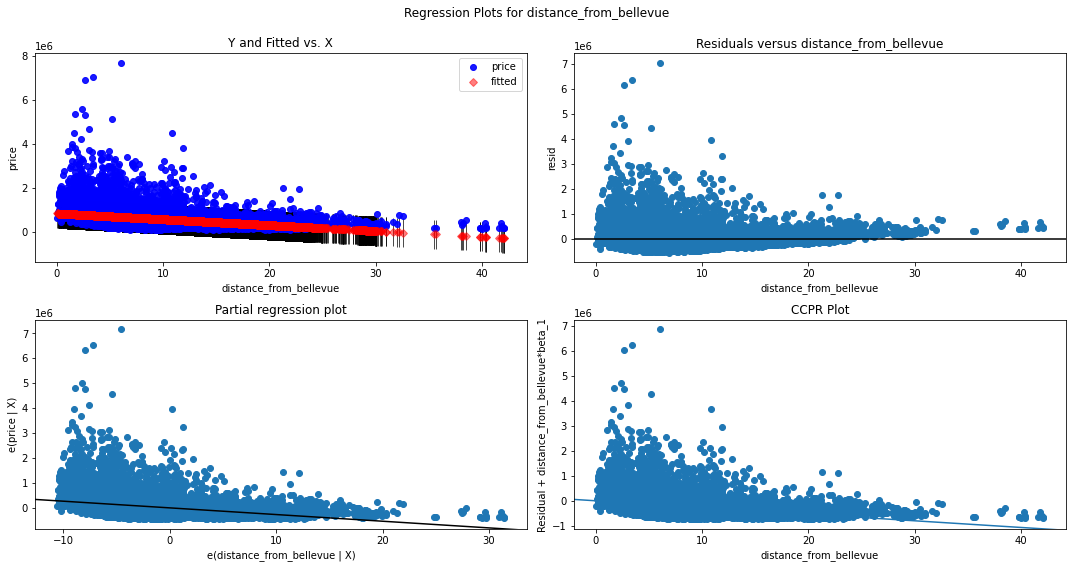

In [43]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(skinny_model, "distance_from_bellevue", fig=fig)
plt.show()

In [39]:
skinnysqft_formula = 'price ~ sqft_living'
skinnysqft_model = ols(skinnysqft_formula, skinnydf).fit()
skinnysqft_model_summary = skinnysqft_model.summary()

skinnysqft_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:57:57   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

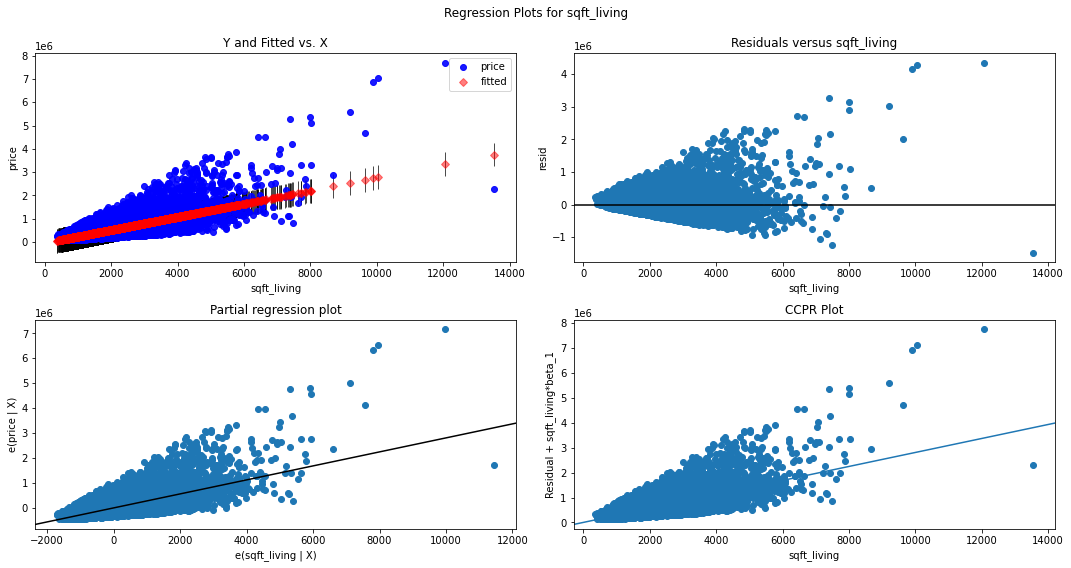

In [40]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(skinnysqft_model, "sqft_living", fig=fig)
plt.show()

In [48]:
skinnymulti_formula = 'price ~ sqft_living + distance_from_bellevue'
skinnymulti_model = ols(skinnymulti_formula, skinnydf).fit()
skinnymulti_model_summary = skinnymulti_model.summary()

skinnymulti_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                 1.609e+04
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:08:55   Log-Likelihood:            -2.9754e+05
No. Observations:               21597   AIC:                         5.951e+05
Df Residuals:                   21594   BIC:                         5.951e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.192e+05   5252.056     41.739      0.000    2.09e+05     2.3e+05
sqft_living              266.9568      1.735    153.828      0.000     263.555     270.358
distance_from_bellevue   -2.2e+04    291.800    -75.394      0.000   -2.26e+04   -2.14e+04
==============================================================================
Omnibus:                    17403.669   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1090170.587
Skew:                           3.426   Prob(JB):                         0.00
Kurtosis:                      37.125   Cond. No.                     7.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

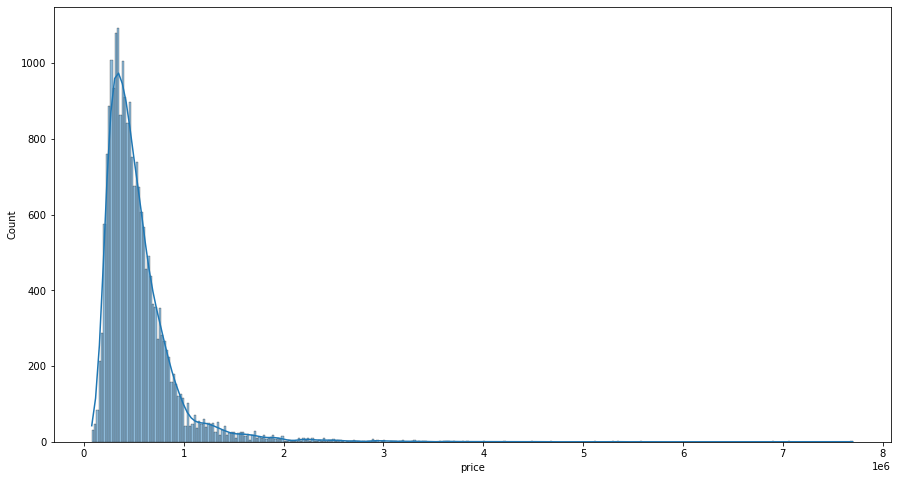

In [17]:
plt.figure(figsize = (15,8))
sns.histplot(skinnydf['price'], kde=True);

In [30]:
cleandf = skinnydf.copy()
cleandf['logprice'] = np.log(cleandf['price'])

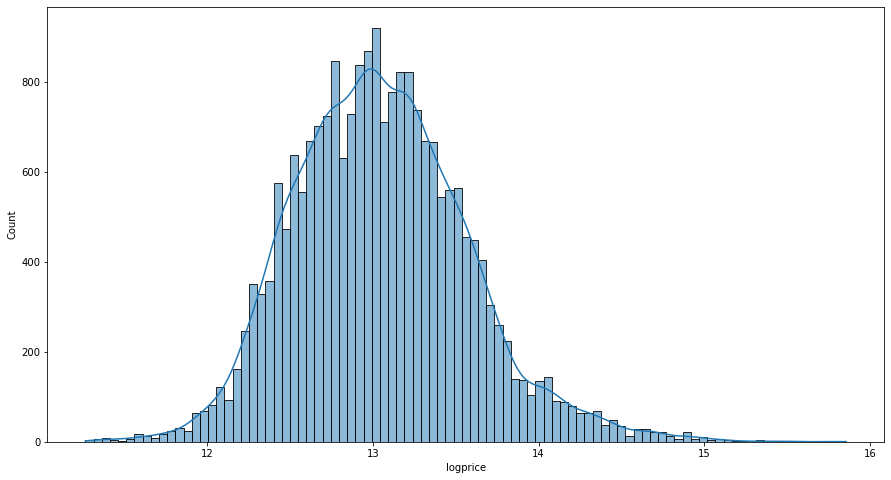

In [31]:
plt.figure(figsize = (15,8))
sns.histplot(cleandf['logprice'], kde=True);

<AxesSubplot:xlabel='distance_from_bellevue', ylabel='Count'>

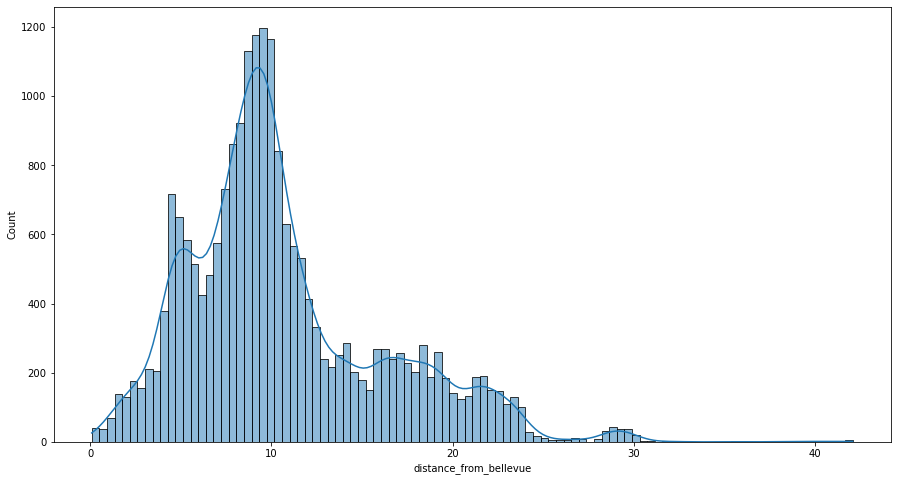

In [21]:
plt.figure(figsize = (15,8))
sns.histplot(skinnydf['distance_from_bellevue'], kde=True)

In [22]:
cleandf = cleandf[cleandf['distance_from_bellevue'] <= 25]

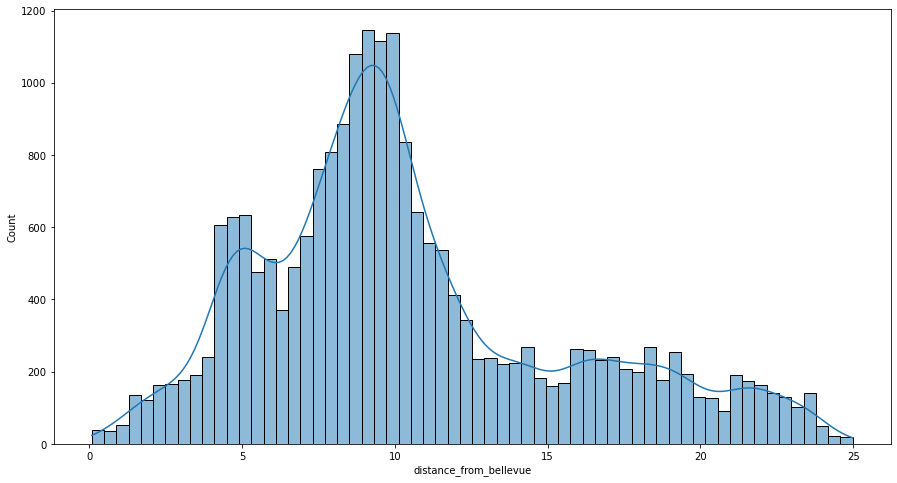

In [23]:
plt.figure(figsize = (15,8))
sns.histplot(cleandf['distance_from_bellevue'], kde=True);

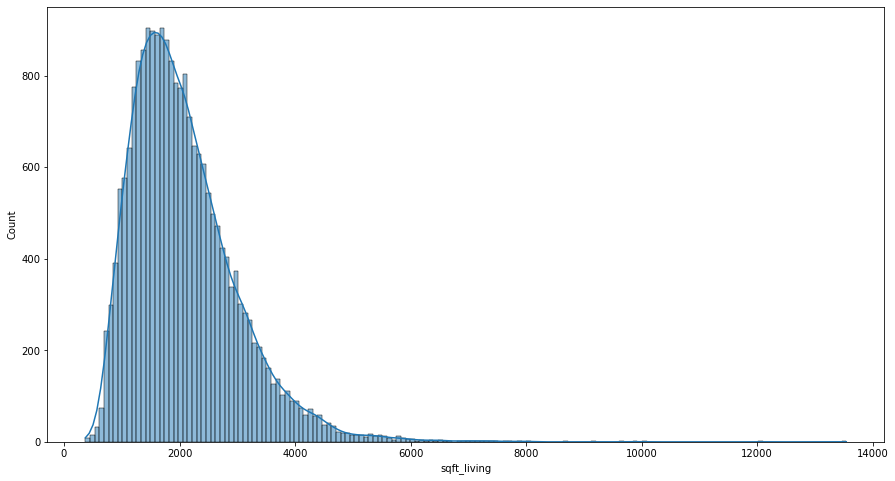

In [24]:
plt.figure(figsize = (15,8))
sns.histplot(skinnydf['sqft_living'], kde=True);

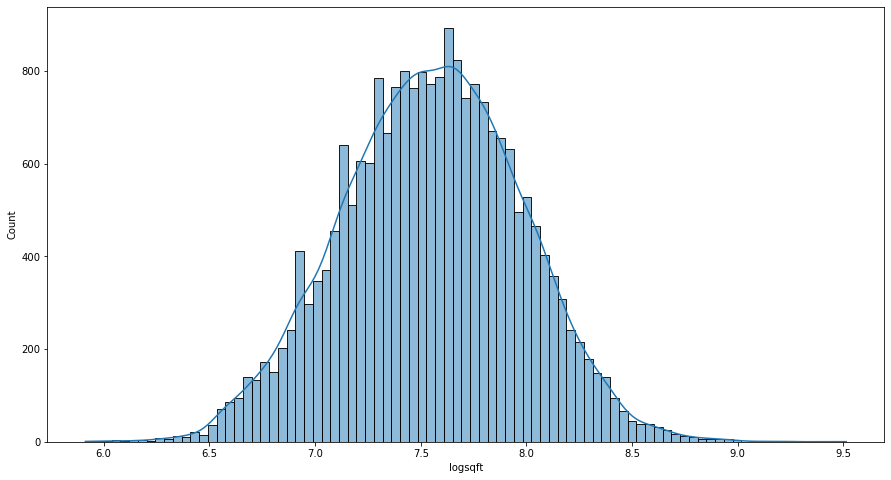

In [32]:
cleandf['logsqft'] = np.log(cleandf['sqft_living'])
plt.figure(figsize = (15,8))
sns.histplot(cleandf['logsqft'], kde=True);

In [82]:
cleandf = cleandf.drop(columns=['price','sqft_living'])
cleandf.head()

,bedrooms,sqft_lot,floors,waterfront,sqft_basement,yr_built,yr_renovated,zipcode,distance_from_bellevue,view_NONE,logprice,logsqft
id,,,,,,,,,,,,
7129300520,3,5650,1.0,0,0,1955,0.0,98178,6.724913,1.0,12.309982,7.073270
6414100192,3,7242,2.0,0,400,1951,1991.0,98125,9.940080,1.0,13.195614,7.851661
5631500400,2,10000,1.0,0,0,1933,0.0,98028,9.571487,1.0,12.100712,6.646391
2487200875,4,5000,1.0,0,910,1965,0.0,98136,10.530416,1.0,13.311329,7.580700
1954400510,3,8080,1.0,0,0,1987,0.0,98074,7.392620,1.0,13.142166,7.426549


In [36]:
clean_formula = 'logprice ~ distance_from_bellevue'
clean_model = ols(clean_formula, cleandf).fit()
clean_model_summary = clean_model.summary()

clean_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     6591.
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:55:56   Log-Likelihood:                -13916.
No. Observations:               21597   AIC:                         2.784e+04
Df Residuals:                   21595   BIC:                         2.785e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 13.5448      0.007   1970.447      0.000      13.531      13.558
distance_from_bellevue    -0.0466      0.001    -81.184      0.000      -0.048      -0.046
==============================================================================
Omnibus:                      732.183   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1271.005
Skew:                           0.291   Prob(JB):                    1.01e-276
Kurtosis:                       4.037   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

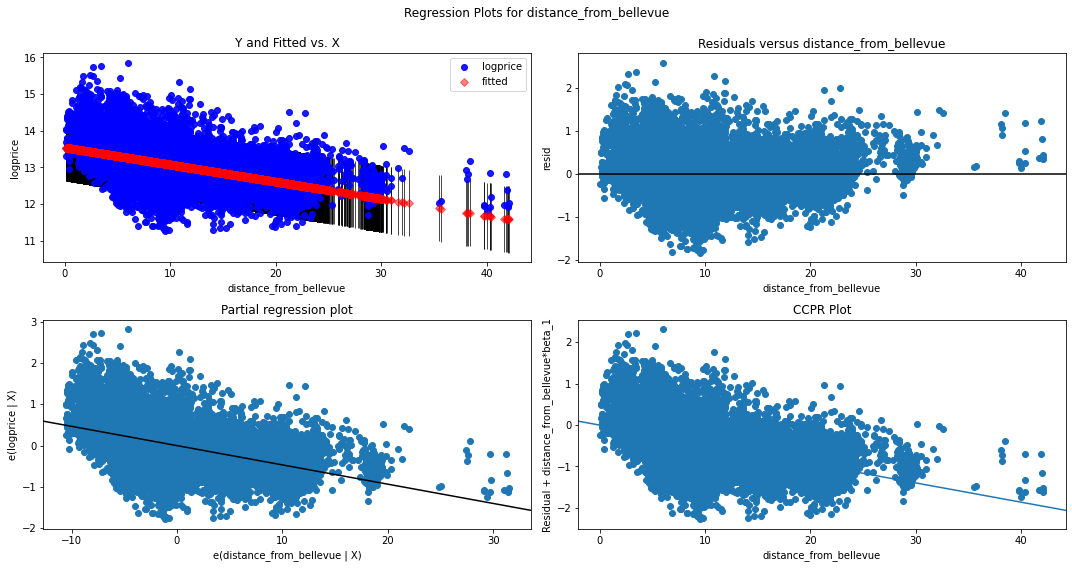

In [38]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(clean_model, "distance_from_bellevue", fig=fig)
plt.show()

In [55]:
cleansqft_formula = 'logprice ~ logsqft'
cleansqft_model = ols(cleansqft_formula, cleandf).fit()
cleansqft_model_summary = cleansqft_model.summary()

cleansqft_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:17:33   Log-Likelihood:                -10231.
No. Observations:               21597   AIC:                         2.047e+04
Df Residuals:                   21595   BIC:                         2.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7234      0.047    142.612      0.000       6.631       6.816
logsqft        0.8376      0.006    134.368      0.000       0.825       0.850
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

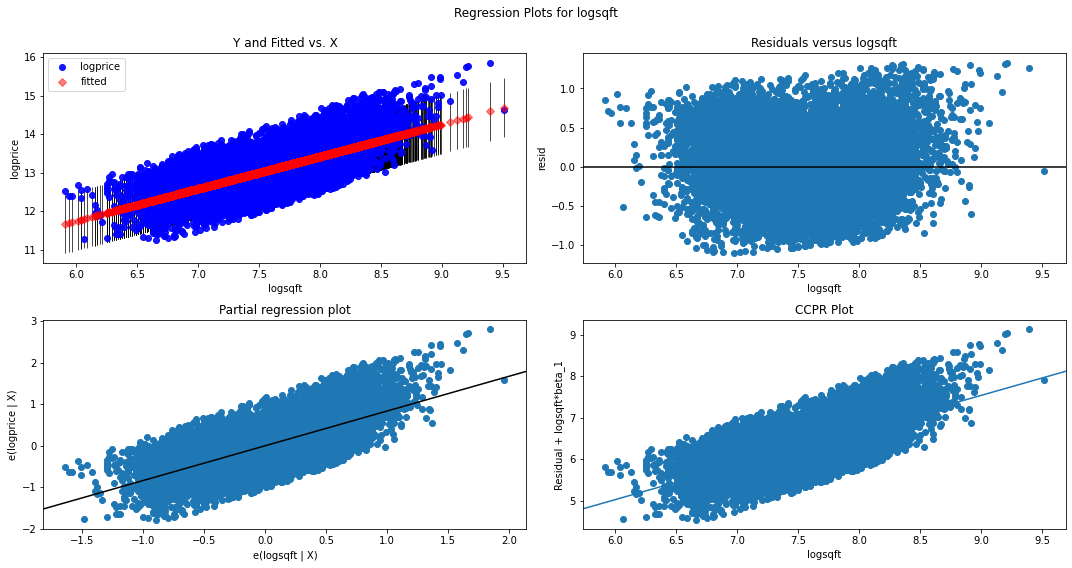

In [56]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(cleansqft_model, "logsqft", fig=fig)
plt.show()

In [57]:
cleanmulti_formula = 'logprice ~ logsqft + distance_from_bellevue '
cleanmulti_model = ols(cleanmulti_formula, cleandf).fit()
cleanmulti_model_summary = cleanmulti_model.summary()

cleanmulti_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                 1.921e+04
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:24:45   Log-Likelihood:                -5754.6
No. Observations:               21597   AIC:                         1.152e+04
Df Residuals:                   21594   BIC:                         1.154e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7.4965      0.039    192.131      0.000       7.420       7.573
logsqft                    0.7939      0.005    156.157      0.000       0.784       0.804
distance_from_bellevue    -0.0416      0.000   -105.314      0.000      -0.042      -0.041
==============================================================================
Omnibus:                      241.613   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              384.698
Skew:                           0.094   Prob(JB):                     2.91e-84
Kurtosis:                       3.626   Cond. No.                         254.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Predictive Modeling

In [113]:
X = cleandf[['distance_from_bellevue']]
y = cleandf[['logprice']]

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [115]:
baseline = DummyRegressor()
baseline.fit(X_train, y_train)
baseline.score(X_train, y_train)
baseline.score(X_test, y_test)

-0.0003779280991382805

In [116]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.22956367766039565

In [64]:
lr.score(X_test, y_test)

0.2364879289999483

In [94]:
cleandf2 = cleandf.drop('logprice', axis=1)

In [95]:
cleandf2 = cleandf.drop('logprice', axis=1)
X2 = cleandf2
y2 = cleandf[['logprice']]

In [96]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)

In [97]:
lr2 = LinearRegression()
lr.fit(X2_train, y2_train)
lr.score(X2_train, y2_train)

0.6937688622400904

In [105]:
selector = RFE(lr, n_features_to_select=6)
selector = selector.fit(X2, y2)

In [106]:
selector.support_ 

array([ True, False,  True,  True, False, False, False, False,  True,
        True,  True])

In [107]:
selector.ranking_

array([1, 6, 1, 1, 4, 2, 5, 3, 1, 1, 1])

In [108]:
X2

,bedrooms,sqft_lot,floors,waterfront,sqft_basement,yr_built,yr_renovated,zipcode,distance_from_bellevue,view_NONE,logsqft
id,,,,,,,,,,,
7129300520,3,5650,1.0,0,0,1955,0.0,98178,6.724913,1.0,7.073270
6414100192,3,7242,2.0,0,400,1951,1991.0,98125,9.940080,1.0,7.851661
5631500400,2,10000,1.0,0,0,1933,0.0,98028,9.571487,1.0,6.646391
2487200875,4,5000,1.0,0,910,1965,0.0,98136,10.530416,1.0,7.580700
1954400510,3,8080,1.0,0,0,1987,0.0,98074,7.392620,1.0,7.426549
...,...,...,...,...,...,...,...,...,...,...,...
263000018,3,1131,3.0,0,0,2009,0.0,98103,9.572031,1.0,7.333023
6600060120,4,5813,2.0,0,0,2014,0.0,98146,9.760026,1.0,7.745003
1523300141,2,1350,2.0,0,0,2009,0.0,98144,4.578875,1.0,6.927558


In [109]:
X3 = cleandf2[['bedrooms','floors','waterfront','distance_from_bellevue','view_NONE','logsqft']]
y3 = cleandf[['logprice']]

In [110]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3)

In [111]:
lr3 = LinearRegression()
lr.fit(X3_train, y3_train)
lr.score(X3_train, y3_train)

0.6840251220505099